# Clone data from GitHub

In [1]:
# Clone the ZZSC9020 project repository from GitHub
!git clone https://github.com/UNSW-ZZSC9020-2023H2/project.git

Cloning into 'project'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 25 (delta 0), reused 2 (delta 0), pack-reused 21
Unpacking objects: 100% (25/25), 121.23 MiB | 8.67 MiB/s, done.
Updating files: 100% (12/12), done.


In [2]:
# Create a data folder
!mkdir -p data

In [3]:
# Joint forecastdemand_nsw files into a single file. 
!cat project/data/forecastdemand_nsw.csv.zip.part* > data/forecastdemand_nsw.csv.zip

In [4]:
# Unzip the data files into the data folder
!unzip data/forecastdemand_nsw.csv.zip -d data
!unzip project/data/temperature_nsw.csv.zip -d data
!unzip project/data/totaldemand_nsw.csv.zip -d data

Archive:  data/forecastdemand_nsw.csv.zip
  inflating: data/forecastdemand_nsw.csv  
  inflating: data/__MACOSX/._forecastdemand_nsw.csv  
Archive:  project/data/temperature_nsw.csv.zip
  inflating: data/temperature_nsw.csv  
  inflating: data/__MACOSX/._temperature_nsw.csv  
Archive:  project/data/totaldemand_nsw.csv.zip
  inflating: data/totaldemand_nsw.csv  
  inflating: data/__MACOSX/._totaldemand_nsw.csv  


In [5]:
# Remove forecastdemand_nsw.csv.zip
!rm data/forecastdemand_nsw.csv.zip

# Import libraries

In [6]:
# for data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# for time series model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from tqdm import tqdm_notebook
#from itertools import product

# for machine learning model


# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Others
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data preprocessing

In [7]:
# Load the data
totaldemand = pd.read_csv('data/totaldemand_nsw.csv',index_col='DATETIME').sort_index()
temperature = pd.read_csv('data/temperature_nsw.csv',index_col='DATETIME').sort_index()
forecastdemand = pd.read_csv('data/forecastdemand_nsw.csv',index_col='DATETIME').sort_index()

In [8]:
# Check for NaN values
print(f'NaN values in totaldemand= {totaldemand.isna().sum().sum()}')
print(f'NaN values in temperature= {temperature.isna().sum().sum()}')
print(f'NaN values in forecastdemand= {forecastdemand.isna().sum().sum()}')

NaN values in totaldemand= 0
NaN values in temperature= 0
NaN values in forecastdemand= 0


In [9]:
# Check for zero or negative values
print(f'Zero or negative values in totaldemand= {((totaldemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in temperature= {((temperature.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in forecastdemand= {((forecastdemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')

Zero or negative values in totaldemand= 0
Zero or negative values in temperature= 36
Zero or negative values in forecastdemand= 0


In [10]:
# Explore extreme temperature values
temperature.loc[temperature['TEMPERATURE']<=0]

,LOCATION,TEMPERATURE
DATETIME,,
2010-03-23 15:00:00,94766.0,-9999.0
2010-04-27 10:00:00,94766.0,-9999.0
2010-05-01 06:00:00,94766.0,-9999.0
2010-06-29 04:30:00,94766.0,-0.2
2010-06-29 05:30:00,94766.0,-0.1
2010-06-29 06:30:00,94766.0,-0.3
2010-06-30 04:30:00,94766.0,-0.3
2010-06-30 05:00:00,94766.0,-0.5
2010-06-30 05:30:00,94766.0,-0.4


In [11]:
# Remove rows with unreasonable values
temperature = temperature.loc[temperature['TEMPERATURE']!=-9999]

In [12]:
# Convert relevant columns to datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
totaldemand.index = pd.to_datetime(totaldemand.index, format=datetime_format)
temperature.index = pd.to_datetime(temperature.index, format=datetime_format)
forecastdemand.index = pd.to_datetime(forecastdemand.index, format=datetime_format)
forecastdemand['LASTCHANGED'] = pd.to_datetime(forecastdemand['LASTCHANGED'], format=datetime_format)

In [13]:
# Drop unwanted columns
totaldemand.drop(['REGIONID'],axis=1,inplace=True)
temperature.drop(['LOCATION'],axis=1,inplace=True)
forecastdemand.drop(['REGIONID','PREDISPATCHSEQNO','PERIODID'],axis=1,inplace=True)

In [14]:
# Create the dataframe for modelling
df = pd.merge(temperature,totaldemand,left_index=True,right_index=True).sort_index()

In [15]:
# Resample the dataframe by equal time intervals (for time series modelling)
interval = '30T'
df_resampled = df.resample(interval).first().sort_index()
print(f'No. of data removed from df after resampling:\n{(df-df_resampled).isna().sum()}')

No. of data removed from df after resampling:
TEMPERATURE    5688
TOTALDEMAND    5688
dtype: int64


In [16]:
# Create a dataframe for comaprison between actual and forecast demands
df_forecast = pd.merge(forecastdemand,totaldemand,left_index=True,right_index=True)
df_forecast['DURATION'] = (df_forecast.index - df_forecast['LASTCHANGED']).astype('timedelta64[h]').astype('int')
df_forecast['ERROR'] = abs(df_forecast['FORECASTDEMAND'] - df_forecast['TOTALDEMAND'])/df_forecast['TOTALDEMAND']*100
df_forecast.drop(['FORECASTDEMAND','TOTALDEMAND','LASTCHANGED'],axis=1,inplace=True)

# Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Temperature Distribution')

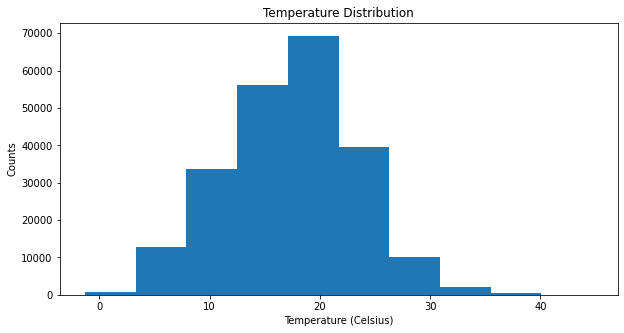

In [22]:
# Plot distribution of temperature
plt.figure(figsize=[10, 5])
plt.hist(df['TEMPERATURE'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Counts')
plt.title('Temperature Distribution')

Text(0.5, 1.0, 'Electricity Demand Distribution')

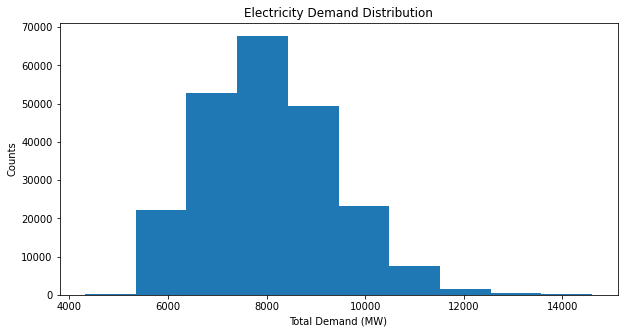

In [23]:
# Plot histogram of electricity demand
plt.figure(figsize=[10, 5])
plt.hist(df['TOTALDEMAND'])
plt.xlabel('Total Demand (MW)')
plt.ylabel('Counts')
plt.title('Electricity Demand Distribution')

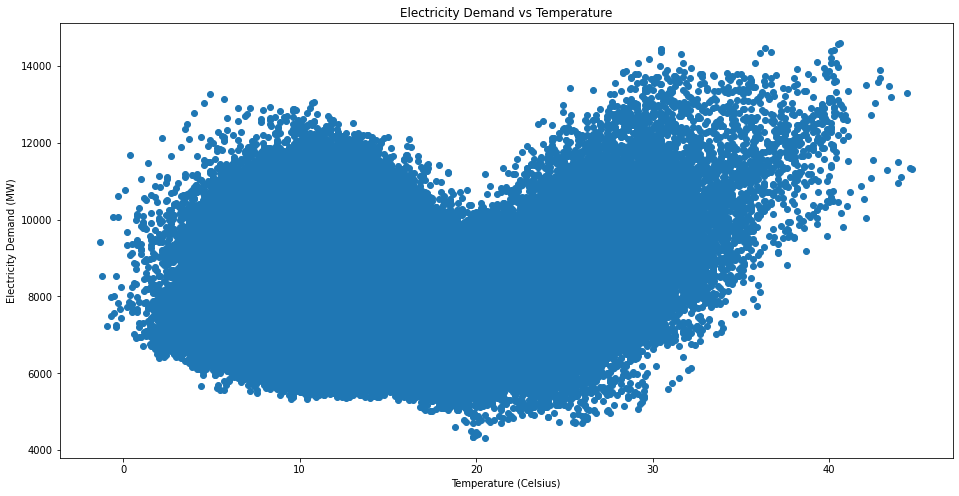

<function matplotlib.pyplot.clf()>

In [19]:
# Plot totaldemand vs temperature
plt.figure(figsize=[16, 8])
plt.scatter(df['TEMPERATURE'], df['TOTALDEMAND'])
plt.ylabel('Electricity Demand (MW)')
plt.xlabel('Temperature (Celsius)')
plt.title('Electricity Demand vs Temperature')
plt.show()
plt.clf

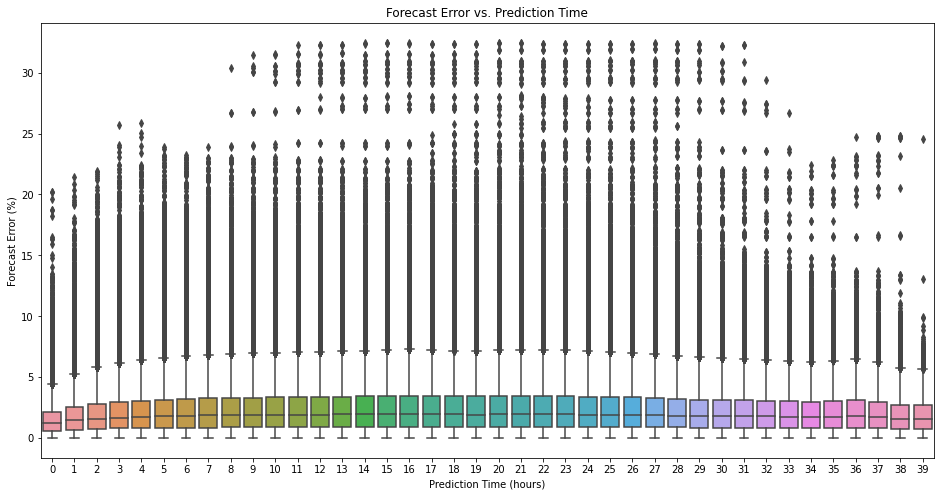

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot forecast error vs prediction time
plt.figure(figsize=[16, 8])
sns.boxplot(x='DURATION', y='ERROR', data=df_forecast).set(
    title='Forecast Error vs. Prediction Time',
    xlabel = 'Prediction Time (hours)',
    ylabel = 'Forecast Error (%)'
    )
plt.show()
plt.clf()

# Key findings from EDA
*   Normal distribution for temperature data
*   Right-skewed distribution for electricity demand data
*   Non-linear (U shape) relationship between electricity demand and temperature
*   Electricity demand is the lowest around 20 degree Celsius
*   Electricity demand increases at a higher rate under extreme hot weather
*   The longest prediction time for forecast demand is around 39 hours ahead of actual demand
*   Prediction tends to be more accurate within 2 hours before actual demand
*   Boxplot shows many outliers of forecast errors which extend to over 30%, indicating poor prediction performance of current model